In [1]:
import os
directory = "datasets"
files = os.listdir(directory)
files

['data1.xlsx',
 'data2.xlsx',
 'data3.xlsx',
 'data4.xlsx',
 'data5.xlsx',
 'data6.xlsx',
 'data7.xlsx',
 'dataset4.xlsx',
 'dataset5.xlsx',
 'dataset6.xlsx',
 'dataset7.xlsx',
 'dataset8.xlsx',
 'dataset9.xlsx',
 'dataset_1_2_3_combined.xlsx']

In [2]:
import pandas as pd

directory = "datasets"

data = pd.concat(
    [
        pd.read_excel(os.path.join(directory, file)).rename(
            columns=lambda x: x.strip().replace(" ", "_").translate(str.maketrans("", "", r"""!"#$%&'()*+,./:;<=>?@[\]^`{|}~"""))
        )
        for file in os.listdir(directory)
        if file.endswith((".xlsx", ".xls"))
    ],
    ignore_index=True, 
)



In [3]:
# Calculate resume and job description similarity (Cosine Similarity)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the job descriptions and resumes
jd_vectors = vectorizer.fit_transform(data['Job_Description'])
resume_vectors = vectorizer.transform(data['Resume'])  # Use transform for consistency
transcript_vectors = vectorizer.transform(data['Transcript'])  # Use transform


In [4]:
jd_vectors

<10174x3153 sparse matrix of type '<class 'numpy.float64'>'
	with 326699 stored elements in Compressed Sparse Row format>

In [5]:
import pickle

# Save the vectorizer model
with open('tfidf_vectorization.pld', 'wb') as file:
    pickle.dump(vectorizer, file)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between resume and job description for each candidate
data['resume_job_similarity'] = [cosine_similarity(resume_vectors[i], jd_vectors[i])[0][0] for i in range(len(data))]

# Calculate cosine similarity between transcript and job description for each candidate
data['transcript_jd_similarity'] = [cosine_similarity(transcript_vectors[i], jd_vectors[i])[0][0] for i in range(len(data))]

# Calculate cosine similarity between transcript and resume for each candidate
data['transcript_resume_similarity'] = [cosine_similarity(transcript_vectors[i], resume_vectors[i])[0][0] for i in range(len(data))]


In [7]:
data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,transcript_resume_similarity
0,jasojo159,Jason Jones,E-commerce Specialist,"Interviewer: Good morning, Jason. It's great t...",Here's a professional resume for Jason Jones:\...,reject,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...,0.134046,0.104116,0.224420
1,annma759,Ann Marshall,Game Developer,Interview Scene\n\nA conference room with a ta...,Here's a professional resume for Ann Marshall:...,select,Strong technical skills in AI and ML.,Help us build the next-generation products as ...,0.148993,0.150978,0.131321
2,patrmc729,Patrick Mcclain,Human Resources Specialist,Interview Setting: A conference room in a medi...,Here's a professional resume for Patrick Mccla...,reject,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...,0.158038,0.112516,0.301784
3,patrgr422,Patricia Gray,E-commerce Specialist,Here's a simulated professional interview for ...,Here's a professional resume for Patricia Gray...,select,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...,0.099547,0.162059,0.342762
4,amangr696,Amanda Gross,E-commerce Specialist,Here's the simulated interview:\n\nInterviewer...,Here's a professional resume for Amanda Gross:...,reject,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...,0.086272,0.170470,0.191605
...,...,...,...,...,...,...,...,...,...,...,...
10169,ananba44,ananya bansal,data engineer,here's a realistic interview transcript for th...,ananya bansal\ncontact information:\n\n* phone...,select,experience gap,\n we are seeking a qualified data engi...,0.323369,0.231874,0.324519
10170,diyasi576,diya singh,product manager,interview transcript for product manager role\...,diya singh\ncontact information:\n\n* email: [...,reject,business acumen,\n we are seeking a qualified product m...,0.271104,0.239326,0.373218
10171,harska507,harshitha kapoor,ui engineer,"interviewer: hi harshitha, thanks for coming i...",harshitha kapoor\nui engineer\n\ncontact infor...,select,cultural fit,\n we are seeking a qualified ui engine...,0.456541,0.260396,0.308366
10172,kabich225,kabir chopra,software engineer,here's a realistic interview transcript for ka...,kabir chopra\ncontact information:\n\n* email:...,reject,technical knowledge,\n we are seeking a qualified software ...,0.324374,0.190960,0.212490


In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Perform sentiment analysis on each transcript
data['sentiment'] = data['Transcript'].apply(lambda transcript: sia.polarity_scores(transcript)['compound'])


In [9]:
from textblob import TextBlob
data['cultural_fit_sentiment'] = data['Reason_for_decision'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [10]:
#confidence score
data['confidence_score'] = data['Transcript'].apply(lambda x: x.count('I think') + x.count('Maybe'))


In [11]:
#job score
def job_fit_analysis(job_desc, transcript):
    # You can use similarity or keyword matching here
    job_keywords = job_desc.split()
    transcript_keywords = transcript.split()
    common_keywords = set(job_keywords).intersection(transcript_keywords)
    return len(common_keywords) / len(job_keywords)

data['job_fit_score'] = data.apply(lambda row: job_fit_analysis(row['Job_Description'], row['Transcript']), axis=1)



In [12]:
#Soft Skills
from textblob import TextBlob

data['soft_skills_sentiment'] = data['Transcript'].apply(lambda x: TextBlob(x).sentiment.polarity)



In [13]:
#clarity score
import textstat
data['clarity_score'] = data['Transcript'].apply(lambda x: textstat.flesch_reading_ease(x))


In [14]:
bins = [0,0.1, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['0-0.1','0.1-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']

# Create a new column with binned values
data['similarity_bin'] = pd.cut(data['resume_job_similarity'], bins=bins, labels=labels, include_lowest=True)

In [15]:
role_decision_counts =data.groupby(['similarity_bin', 'decision','Role']).size().unstack(fill_value=0)

C:\Users\yalla\AppData\Local\Temp\ipykernel_2512\1400410729.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  role_decision_counts =data.groupby(['similarity_bin', 'decision','Role']).size().unstack(fill_value=0)


In [16]:
role_decision_counts

Role                     AI Engineer  AI Researcher  AR/VR Developer  \
similarity_bin decision                                                
0-0.1          reject              0             17                9   
               select              0             18               10   
0.1-0.2        reject              0             82               14   
               select              0             78               15   
0.2-0.4        reject              0              9               89   
               select              1             20               87   
0.4-0.6        reject              5              1                9   
               select              7              0                4   
0.6-0.8        reject              0              0                0   
               select              0              0                0   
0.8-1          reject              0              0                0   
               select              0              0                0   

Role                     Blockchain Developer  Business Analyst  \
similarity_bin decision                                           
0-0.1          reject                      10                 1   
               select                       9                 0   
0.1-0.2        reject                       8                26   
               select                       7                27   
0.2-0.4        reject                      98                75   
               select                     114                86   
0.4-0.6        reject                       2                 3   
               select                       3                 3   
0.6-0.8        reject                       0                 2   
               select                       0                 3   
0.8-1          reject                       0                 0   
               select                       0                 0   

Role                     Cloud Architect  Cloud Engineer  Content Writer  \
similarity_bin decision                                                    
0-0.1          reject                  2              10               4   
               select                  1               8               2   
0.1-0.2        reject                 51              85               7   
               select                 54              64              12   
0.2-0.4        reject                 64              41             100   
               select                 71              26              98   
0.4-0.6        reject                  6               2               7   
               select                  4               4               2   
0.6-0.8        reject                  1               0               3   
               select                  0               0               3   
0.8-1          reject                  0               0               0   
               select                  0               0               0   

Role                     Cybersecurity Analyst  Cybersecurity Specialist  ...  \
similarity_bin decision                                                   ...   
0-0.1          reject                       25                         0  ...   
               select                       26                         0  ...   
0.1-0.2        reject                       79                         0  ...   
               select                       76                         0  ...   
0.2-0.4        reject                        9                         0  ...   
               select                       15                         0  ...   
0.4-0.6        reject                        3                         3  ...   
               select                        1                         1  ...   
0.6-0.8        reject                        0                         3  ...   
               select                        0                         2  ...   
0.8-1          

In [17]:
print(role_decision_counts.columns)


Index(['AI Engineer', 'AI Researcher', 'AR/VR Developer',
       'Blockchain Developer', 'Business Analyst', 'Cloud Architect',
       'Cloud Engineer', 'Content Writer', 'Cybersecurity Analyst',
       'Cybersecurity Specialist', 'Data Analyst', 'Data Architect',
       'Data Engineer', 'Data Scientist', 'Database Administrator',
       'DevOps Engineer', 'Digital Marketing Specialist',
       'E-commerce Specialist', 'Full Stack Developer', 'Game Developer',
       'Graphic Designer', 'HR Specialist', 'Human Resources Specialist',
       'IT Support Specialist', 'Machine Learning Engineer',
       'Mobile App Developer', 'Network Engineer', 'Product Manager',
       'Project Manager', 'QA Engineer', 'Robotics Engineer',
       'Software Developer', 'Software Engineer', 'System Administrator',
       'UI Designer', 'UI Engineer', 'UI/UX Designer', 'UX Designer',
       'data analyst', 'data engineer', 'data scientist', 'product manager',
       'software engineer', 'ui designer', 'ui 

In [18]:
selected_counts = role_decision_counts.xs(key='select', level='decision', axis=0)


In [19]:
thresholds = selected_counts.idxmax(axis=1).reset_index()
thresholds.columns = ['Role', 'Threshold_Similarity_Bin']

In [20]:
thresholds

,Role,Threshold_Similarity_Bin
0,0-0.1,data engineer
1,0.1-0.2,Software Engineer
2,0.2-0.4,Data Scientist
3,0.4-0.6,Data Engineer
4,0.6-0.8,Product Manager
5,0.8-1,AI Engineer


C:\Users\yalla\AppData\Local\Temp\ipykernel_2512\2089454991.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['similarity_bin', 'decision']).size().unstack(fill_value=0)


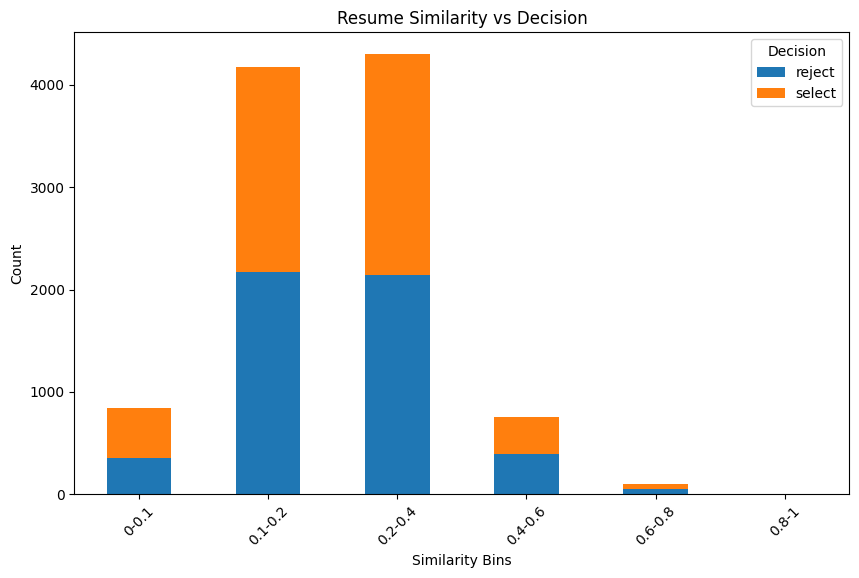

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the similarity distribution grouped by decision
grouped_data = data.groupby(['similarity_bin', 'decision']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Resume Similarity vs Decision')
plt.ylabel('Count')
plt.xlabel('Similarity Bins')
plt.xticks(rotation=45)
plt.legend(title='Decision')
plt.show()


In [22]:
# Encoding the target variable (select/reject)
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
data['decision'] = le.fit_transform(data['decision'])

In [23]:
# Calculate acceptance rate
data['acceptance_rate'] = data.groupby(['similarity_bin', 'Role'], observed=True)['decision'].transform(
    lambda x: x.mean()
)


In [24]:
data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,transcript_resume_similarity,sentiment,cultural_fit_sentiment,confidence_score,job_fit_score,soft_skills_sentiment,clarity_score,similarity_bin,acceptance_rate
0,jasojo159,Jason Jones,E-commerce Specialist,"Interviewer: Good morning, Jason. It's great t...",Here's a professional resume for Jason Jones:\...,0,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...,0.134046,0.104116,0.224420,0.9993,0.000000,3,0.409091,0.393933,57.87,0.1-0.2,0.513369
1,annma759,Ann Marshall,Game Developer,Interview Scene\n\nA conference room with a ta...,Here's a professional resume for Ann Marshall:...,1,Strong technical skills in AI and ML.,Help us build the next-generation products as ...,0.148993,0.150978,0.131321,0.9993,0.216667,1,0.411765,0.128213,58.08,0.1-0.2,0.459459
2,patrmc729,Patrick Mcclain,Human Resources Specialist,Interview Setting: A conference room in a medi...,Here's a professional resume for Patrick Mccla...,0,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...,0.158038,0.112516,0.301784,0.9988,0.000000,1,0.421053,0.216948,57.57,0.1-0.2,0.489247
3,patrgr422,Patricia Gray,E-commerce Specialist,Here's a simulated professional interview for ...,Here's a professional resume for Patricia Gray...,1,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...,0.099547,0.162059,0.342762,0.9993,1.000000,1,0.318182,0.292263,48.30,0-0.1,0.456522
4,amangr696,Amanda Gross,E-commerce Specialist,Here's the simulated interview:\n\nInterviewer...,Here's a professional resume for Amanda Gross:...,0,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...,0.086272,0.170470,0.191605,0.9976,0.000000,0,0.550000,0.243381,58.28,0-0.1,0.456522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,ananba44,ananya bansal,data engineer,here's a realistic interview transcript for th...,ananya bansal\ncontact information:\n\n* phone...,1,experience gap,\n we are seeking a qualified data engi...,0.323369,0.231874,0.324519,0.9987,0.000000,0,0.428571,0.115636,66.44,0.2-0.4,0.476923
10170,diyasi576,diya singh,product manager,interview transcript for product manager role\...,diya singh\ncontact information:\n\n* email: [...,0,business acumen,\n we are seeking a qualified product m...,0.271104,0.239326,0.373218,0.9992,0.000000,0,0.567568,0.165130,53.71,0.2-0.4,0.412903
10171,harska507,harshitha kapoor,ui engineer,"interviewer: hi harshitha, thanks for coming i...",harshitha kapoor\nui engineer\n\ncontact infor...,1,cultural fit,\n we are seeking a qualified ui engine...,0.456541,0.260396,0.308366,0.9996,0.250000,0,0.500000,0.261346,65.22,0.4-0.6,0.558824
10172,kabich225,kabir chopra,software engineer,here's a realistic interview transcript for ka...,kabir chopra\ncontact information:\n\n* email:...,0,technical knowledge,\n we are seeking a qualified software ...,0.324374,0.190960,0.212490,0.9986,0.000000,0,0.527778,0.172396,56.35,0.2-0.4,0.467105


In [25]:
data.groupby(['similarity_bin', 'Role']).size()


C:\Users\yalla\AppData\Local\Temp\ipykernel_2512\2495977276.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['similarity_bin', 'Role']).size()


similarity_bin  Role                
0-0.1           AI Engineer              0
                AI Researcher           35
                AR/VR Developer         19
                Blockchain Developer    19
                Business Analyst         1
                                        ..
0.8-1           data scientist           0
                product manager          0
                software engineer        0
                ui designer              0
                ui engineer              0
Length: 270, dtype: int64

In [26]:
data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,transcript_resume_similarity,sentiment,cultural_fit_sentiment,confidence_score,job_fit_score,soft_skills_sentiment,clarity_score,similarity_bin,acceptance_rate
0,jasojo159,Jason Jones,E-commerce Specialist,"Interviewer: Good morning, Jason. It's great t...",Here's a professional resume for Jason Jones:\...,0,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...,0.134046,0.104116,0.224420,0.9993,0.000000,3,0.409091,0.393933,57.87,0.1-0.2,0.513369
1,annma759,Ann Marshall,Game Developer,Interview Scene\n\nA conference room with a ta...,Here's a professional resume for Ann Marshall:...,1,Strong technical skills in AI and ML.,Help us build the next-generation products as ...,0.148993,0.150978,0.131321,0.9993,0.216667,1,0.411765,0.128213,58.08,0.1-0.2,0.459459
2,patrmc729,Patrick Mcclain,Human Resources Specialist,Interview Setting: A conference room in a medi...,Here's a professional resume for Patrick Mccla...,0,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...,0.158038,0.112516,0.301784,0.9988,0.000000,1,0.421053,0.216948,57.57,0.1-0.2,0.489247
3,patrgr422,Patricia Gray,E-commerce Specialist,Here's a simulated professional interview for ...,Here's a professional resume for Patricia Gray...,1,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...,0.099547,0.162059,0.342762,0.9993,1.000000,1,0.318182,0.292263,48.30,0-0.1,0.456522
4,amangr696,Amanda Gross,E-commerce Specialist,Here's the simulated interview:\n\nInterviewer...,Here's a professional resume for Amanda Gross:...,0,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...,0.086272,0.170470,0.191605,0.9976,0.000000,0,0.550000,0.243381,58.28,0-0.1,0.456522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,ananba44,ananya bansal,data engineer,here's a realistic interview transcript for th...,ananya bansal\ncontact information:\n\n* phone...,1,experience gap,\n we are seeking a qualified data engi...,0.323369,0.231874,0.324519,0.9987,0.000000,0,0.428571,0.115636,66.44,0.2-0.4,0.476923
10170,diyasi576,diya singh,product manager,interview transcript for product manager role\...,diya singh\ncontact information:\n\n* email: [...,0,business acumen,\n we are seeking a qualified product m...,0.271104,0.239326,0.373218,0.9992,0.000000,0,0.567568,0.165130,53.71,0.2-0.4,0.412903
10171,harska507,harshitha kapoor,ui engineer,"interviewer: hi harshitha, thanks for coming i...",harshitha kapoor\nui engineer\n\ncontact infor...,1,cultural fit,\n we are seeking a qualified ui engine...,0.456541,0.260396,0.308366,0.9996,0.250000,0,0.500000,0.261346,65.22,0.4-0.6,0.558824
10172,kabich225,kabir chopra,software engineer,here's a realistic interview transcript for ka...,kabir chopra\ncontact information:\n\n* email:...,0,technical knowledge,\n we are seeking a qualified software ...,0.324374,0.190960,0.212490,0.9986,0.000000,0,0.527778,0.172396,56.35,0.2-0.4,0.467105


In [27]:
data['resume_screening_score'] = (
    0.5 * data['resume_job_similarity'] + 
    0.3 * data['cultural_fit_sentiment'] +
    0.2 * data['clarity_score']
)


In [28]:
data['interview_performance_score'] = (
    0.3 * data['sentiment'] + 
    0.3 * data['cultural_fit_sentiment'] +
    0.2 * data['soft_skills_sentiment'] +
    0.2 * data['clarity_score']
)

In [29]:
sorted_data = data.sort_values(by='resume_screening_score', ascending=False)


In [30]:
sorted_data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,...,sentiment,cultural_fit_sentiment,confidence_score,job_fit_score,soft_skills_sentiment,clarity_score,similarity_bin,acceptance_rate,resume_screening_score,interview_performance_score
7948,U_50,Ava,Software Engineer,"**Interviewer:** Ava, thanks for coming in tod...",**Ava**\n**Software Engineer**\n\n**Contact In...,0,"Insufficient mastery of RESTful APIs, Version ...",Join our team as a Software Engineer and lever...,0.160877,0.077609,...,0.9990,0.500000,7,0.304348,0.173022,87.52,0.1-0.2,0.486792,17.734439,17.988304
7082,uppaup83,Bob Miller,UI Engineer,Here's a simulated interview for a UI Engineer...,Here's a sample resume for Bob Miller:\n\n**Bo...,0,Poor cultural fit.,Here is a job description for a UI Engineer ro...,0.540792,0.273351,...,0.9979,0.033333,3,0.079096,0.161227,86.91,0.4-0.6,0.465347,17.662396,17.723615
7482,uppaup483,Charlie Brown,Data Scientist,Here's a simulated interview for a Data Scient...,"Here's a resume for Charlie Brown, the lovable...",0,Lack of enthusiasm or motivation.,**Job Title: Data Scientist**\n\n**Job Summary...,0.501002,0.222827,...,0.9943,0.000000,7,0.061983,0.250303,84.27,0.4-0.6,0.440476,17.104501,17.202351
884,tinaho765,Tina Hood,AR/VR Developer,Here's the simulated interview:\n\nInterviewer...,Here's a sample resume for Tina Hood:\n\nTina ...,1,Impressive leadership and communication abilit...,We're seeking a talented AR/VR Developer to wo...,0.213926,0.134525,...,0.9451,1.000000,0,0.235294,0.349306,79.77,0.2-0.4,0.494318,16.360963,16.607391
7018,uppaup19,Alice Brown,Data Scientist,Here's a simulated interview for a Data Scient...,Here is a sample resume for Alice Brown:\n\n**...,0,Unsatisfactory references or background check.,Here is a job description for a Data Scientist...,0.520003,0.220336,...,0.9950,0.000000,6,0.067061,0.281429,79.87,0.4-0.6,0.440476,16.234001,16.328786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9521,rivash0571,ritul choudhury,software engineer,**interview transcript**\n\n**interviewer:** r...,**ritul choudhury**\n**software engineer candi...,1,"expected_experience : 9+ years, domains: e-com...",demonstrated strong skills relevant to the rol...,0.139519,0.171627,...,0.9993,0.000000,0,0.583333,0.305901,38.62,0.1-0.2,0.333333,7.793759,8.084970
9774,rivash0830,kairav kumar,product manager,**interview transcript: kairav kumar - product...,**kairav kumar: product manager candidate**\n\...,1,"expected_experience : 0-2 years, domains: tech...","communicated ideas clearly and effectively., s...",0.136969,0.106278,...,0.9994,0.000000,0,0.500000,0.294900,38.42,0.1-0.2,0.447619,7.752484,8.042800
9844,rivash0901,taksha soni,data engineer,**interview transcript: taksha soni - data eng...,**taksha soni: data engineer extraordinaire**\...,1,"expected_experience : 0-2 years, domains: logi...",showed great enthusiasm and potential for grow...,0.077531,0.090255,...,0.9972,0.000000,0,0.333333,0.193175,38.01,0-0.1,0.640000,7.640766,7.939795
9358,rivash0401,pratiti raj,data analyst,"**interviewer:** dr. rachel lee, manager, busi...",**pratiti raj: data analyst extraordinaire**\n...,1,"expected_experience : 6-8 years, domains: mark...","communicated ideas clearly and effectively., e...",0.042260,0.054497,...,0.9994,0.000000,0,0.333333,0.260748,38.01,0-0.1,0.764706,7.623130,7.953970


In [31]:
threshold = 0.75
filtered_data = data[data['resume_screening_score'] >= threshold]


In [32]:
filtered_data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,...,sentiment,cultural_fit_sentiment,confidence_score,job_fit_score,soft_skills_sentiment,clarity_score,similarity_bin,acceptance_rate,resume_screening_score,interview_performance_score
0,jasojo159,Jason Jones,E-commerce Specialist,"Interviewer: Good morning, Jason. It's great t...",Here's a professional resume for Jason Jones:\...,0,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...,0.134046,0.104116,...,0.9993,0.000000,3,0.409091,0.393933,57.87,0.1-0.2,0.513369,11.641023,11.952577
1,annma759,Ann Marshall,Game Developer,Interview Scene\n\nA conference room with a ta...,Here's a professional resume for Ann Marshall:...,1,Strong technical skills in AI and ML.,Help us build the next-generation products as ...,0.148993,0.150978,...,0.9993,0.216667,1,0.411765,0.128213,58.08,0.1-0.2,0.459459,11.755497,12.006433
2,patrmc729,Patrick Mcclain,Human Resources Specialist,Interview Setting: A conference room in a medi...,Here's a professional resume for Patrick Mccla...,0,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...,0.158038,0.112516,...,0.9988,0.000000,1,0.421053,0.216948,57.57,0.1-0.2,0.489247,11.593019,11.857030
3,patrgr422,Patricia Gray,E-commerce Specialist,Here's a simulated professional interview for ...,Here's a professional resume for Patricia Gray...,1,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...,0.099547,0.162059,...,0.9993,1.000000,1,0.318182,0.292263,48.30,0-0.1,0.456522,10.009774,10.318243
4,amangr696,Amanda Gross,E-commerce Specialist,Here's the simulated interview:\n\nInterviewer...,Here's a professional resume for Amanda Gross:...,0,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...,0.086272,0.170470,...,0.9976,0.000000,0,0.550000,0.243381,58.28,0-0.1,0.456522,11.699136,12.003956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,ananba44,ananya bansal,data engineer,here's a realistic interview transcript for th...,ananya bansal\ncontact information:\n\n* phone...,1,experience gap,\n we are seeking a qualified data engi...,0.323369,0.231874,...,0.9987,0.000000,0,0.428571,0.115636,66.44,0.2-0.4,0.476923,13.449684,13.610737
10170,diyasi576,diya singh,product manager,interview transcript for product manager role\...,diya singh\ncontact information:\n\n* email: [...,0,business acumen,\n we are seeking a qualified product m...,0.271104,0.239326,...,0.9992,0.000000,0,0.567568,0.165130,53.71,0.2-0.4,0.412903,10.877552,11.074786
10171,harska507,harshitha kapoor,ui engineer,"interviewer: hi harshitha, thanks for coming i...",harshitha kapoor\nui engineer\n\ncontact infor...,1,cultural fit,\n we are seeking a qualified ui engine...,0.456541,0.260396,...,0.9996,0.250000,0,0.500000,0.261346,65.22,0.4-0.6,0.558824,13.347270,13.471149
10172,kabich225,kabir chopra,software engineer,here's a realistic interview transcript for ka...,kabir chopra\ncontact information:\n\n* email:...,0,technical knowledge,\n we are seeking a qualified software ...,0.324374,0.190960,...,0.9986,0.000000,0,0.527778,0.172396,56.35,0.2-0.4,0.467105,11.432187,11.604059


In [33]:
data['final_score'] = 0.6 * data['resume_screening_score'] + 0.4 * data['interview_performance_score']


In [34]:
data

,ID,Name,Role,Transcript,Resume,decision,Reason_for_decision,Job_Description,resume_job_similarity,transcript_jd_similarity,...,cultural_fit_sentiment,confidence_score,job_fit_score,soft_skills_sentiment,clarity_score,similarity_bin,acceptance_rate,resume_screening_score,interview_performance_score,final_score
0,jasojo159,Jason Jones,E-commerce Specialist,"Interviewer: Good morning, Jason. It's great t...",Here's a professional resume for Jason Jones:\...,0,Lacked leadership skills for a senior position.,Be part of a passionate team at the forefront ...,0.134046,0.104116,...,0.000000,3,0.409091,0.393933,57.87,0.1-0.2,0.513369,11.641023,11.952577,11.765644
1,annma759,Ann Marshall,Game Developer,Interview Scene\n\nA conference room with a ta...,Here's a professional resume for Ann Marshall:...,1,Strong technical skills in AI and ML.,Help us build the next-generation products as ...,0.148993,0.150978,...,0.216667,1,0.411765,0.128213,58.08,0.1-0.2,0.459459,11.755497,12.006433,11.855871
2,patrmc729,Patrick Mcclain,Human Resources Specialist,Interview Setting: A conference room in a medi...,Here's a professional resume for Patrick Mccla...,0,Insufficient system design expertise for senio...,We need a Human Resources Specialist to enhanc...,0.158038,0.112516,...,0.000000,1,0.421053,0.216948,57.57,0.1-0.2,0.489247,11.593019,11.857030,11.698623
3,patrgr422,Patricia Gray,E-commerce Specialist,Here's a simulated professional interview for ...,Here's a professional resume for Patricia Gray...,1,Impressive leadership and communication abilit...,Be part of a passionate team at the forefront ...,0.099547,0.162059,...,1.000000,1,0.318182,0.292263,48.30,0-0.1,0.456522,10.009774,10.318243,10.133161
4,amangr696,Amanda Gross,E-commerce Specialist,Here's the simulated interview:\n\nInterviewer...,Here's a professional resume for Amanda Gross:...,0,Lacked leadership skills for a senior position.,We are looking for an experienced E-commerce S...,0.086272,0.170470,...,0.000000,0,0.550000,0.243381,58.28,0-0.1,0.456522,11.699136,12.003956,11.821064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,ananba44,ananya bansal,data engineer,here's a realistic interview transcript for th...,ananya bansal\ncontact information:\n\n* phone...,1,experience gap,\n we are seeking a qualified data engi...,0.323369,0.231874,...,0.000000,0,0.428571,0.115636,66.44,0.2-0.4,0.476923,13.449684,13.610737,13.514106
10170,diyasi576,diya singh,product manager,interview transcript for product manager role\...,diya singh\ncontact information:\n\n* email: [...,0,business acumen,\n we are seeking a qualified product m...,0.271104,0.239326,...,0.000000,0,0.567568,0.165130,53.71,0.2-0.4,0.412903,10.877552,11.074786,10.956446
10171,harska507,harshitha kapoor,ui engineer,"interviewer: hi harshitha, thanks for coming i...",harshitha kapoor\nui engineer\n\ncontact infor...,1,cultural fit,\n we are seeking a qualified ui engine...,0.456541,0.260396,...,0.250000,0,0.500000,0.261346,65.22,0.4-0.6,0.558824,13.347270,13.471149,13.396822
10172,kabich225,kabir chopra,software engineer,here's a realistic interview transcript for ka...,kabir chopra\ncontact information:\n\n* email:...,0,technical knowledge,\n we are seeking a qualified software ...,0.324374,0.190960,...,0.000000,0,0.527778,0.172396,56.35,0.2-0.4,0.467105,11.432187,11.604059,11.500936
